# 레퍼런스 

- https://keras.io/examples/vision/autoencoder/
- https://blog.keras.io/building-autoencoders-in-keras.html
- https://github.com/hwk0702/keras2torch/blob/main/Computer_Vision/Convolutional%20autoencoder%20for%20image%20denoising/Convolutional_Autoencoder_for_image_denoising.ipynb

In [108]:
import random
import os

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

# Setup

In [109]:
def preprocess(array):
    # 정규화 및 reshape 용 
    array = array.astype('float32') / 255.0 
    array = array.reshape(-1,28,28,1)
    return array 

def noise(array):
    #noise 추가 
    noise_factor = 0.4 
    noisy_array = array + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    #array1 : 원본 이미지
    #array2 : 노이지 이미지 
    """
    램덤하게 10개 이미지 출력 
    """

    n = 10

#     indices = np.random.randint(len(array1), size=n)
    indices = np.random.randint(10, size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


# Prepare Data 

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


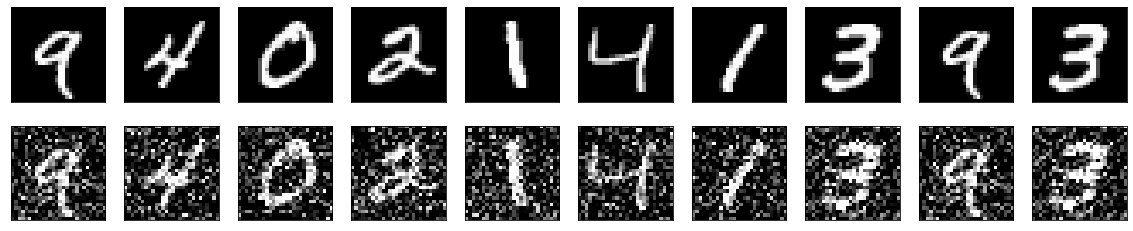

In [128]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
mnist = torchvision.datasets.mnist.MNIST(root='mnist_data', download=True)
train_data, test_data = mnist.train_data, mnist.test_data

# Normalize and reshape the data
train_data = preprocess(train_data.numpy())
test_data = preprocess(test_data.numpy())

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

noisy_train_data = np.array(noisy_train_data, dtype='float32')
noisy_test_data = np.array(noisy_test_data, dtype='float32')

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

# 모델 선언 

In [111]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out 

device = 'cuda:0'
model = AutoEncoder().to(device)
summary(model,input_size=(1,28,28),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
   ConvTranspose2d-9           [-1, 32, 28, 28]           9,248
             ReLU-10           [-1, 32, 28, 28]               0
           Conv2d-11            [-1, 1, 28, 28]             289
          Sigmoid-12            [-1, 1, 28, 28]               0
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
---------------------------------

# 데이터 로더 

In [130]:
from torch.utils.data import DataLoader,dataset

if train_data.shape[1] != 1:
    train_data = train_data.swapaxes(1,-1)
    test_data = test_data.swapaxes(1,-1)
    
train_dataloader = DataLoader(train_data,batch_size=128,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=128,shuffle=True)

# 학습 

In [113]:
criterion = nn.BCELoss() #binary cross entropy 
optimizer = optim.Adam(model.parameters())

In [114]:
n_epochs = 200
model.to(device)

for epoch in range(n_epochs):
    train_loss,val_loss = 0,0

    model.train()
    for train_data in train_dataloader:
        optimizer.zero_grad()
        x = train_data.to(device)
        y = train_data.to(device)

        pred = model(x)
        loss = criterion(pred,y)

        loss.backward()
        optimizer.step() 

        train_loss += float(loss)
    
    model.eval()
    with torch.no_grad():
        for val_data in test_dataloader:
            x_val, y_val = val_data.to(device), val_data.to(device)

            pred_val = model(x_val)
            loss_val = criterion(pred_val,y_val)

            val_loss += float(loss_val)
    train_loss_ep = float(train_loss/len(train_dataloader))
    val_loss_ep = float(val_loss/len(test_dataloader))

    print(f'EPOCH : {epoch} | loss : {train_loss_ep:5f} val : {val_loss_ep:5f}')



EPOCH : 0 | loss : 0.144362 val : 0.075340
EPOCH : 1 | loss : 0.072674 val : 0.070990
EPOCH : 2 | loss : 0.070121 val : 0.069345
EPOCH : 3 | loss : 0.068815 val : 0.068310
EPOCH : 4 | loss : 0.067923 val : 0.067525
EPOCH : 5 | loss : 0.067262 val : 0.066991
EPOCH : 6 | loss : 0.066781 val : 0.066563
EPOCH : 7 | loss : 0.066388 val : 0.066192
EPOCH : 8 | loss : 0.066069 val : 0.065853
EPOCH : 9 | loss : 0.065800 val : 0.065646
EPOCH : 10 | loss : 0.065570 val : 0.065449
EPOCH : 11 | loss : 0.065361 val : 0.065261
EPOCH : 12 | loss : 0.065183 val : 0.065064
EPOCH : 13 | loss : 0.065021 val : 0.064985
EPOCH : 14 | loss : 0.064859 val : 0.064810
EPOCH : 15 | loss : 0.064727 val : 0.064694
EPOCH : 16 | loss : 0.064591 val : 0.064492
EPOCH : 17 | loss : 0.064473 val : 0.064370
EPOCH : 18 | loss : 0.064355 val : 0.064329
EPOCH : 19 | loss : 0.064257 val : 0.064312
EPOCH : 20 | loss : 0.064165 val : 0.064108
EPOCH : 21 | loss : 0.064065 val : 0.063999
EPOCH : 22 | loss : 0.063986 val : 0.06388

KeyboardInterrupt: 

# 테스트 

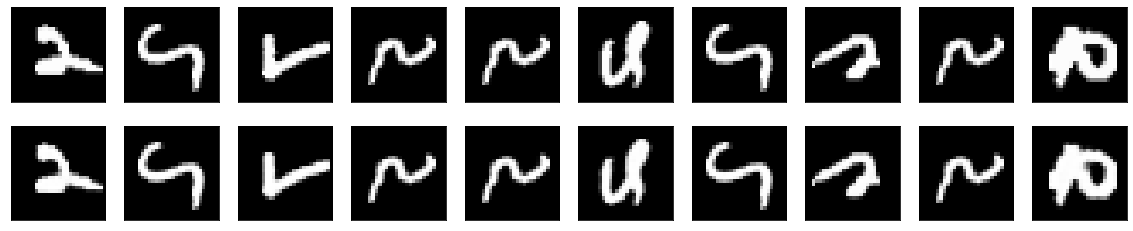

In [115]:
pred_test = None

for test_data in test_dataloader:
    
    model.eval()
    with torch.no_grad():
        pred_test = model(test_data.to(device))
        
display(test_data,pred_test.detach().to('cpu'))

# Denosing model 

In [136]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
mnist = torchvision.datasets.mnist.MNIST(root='mnist_data', download=True)
train_data, test_data = mnist.train_data, mnist.test_data

# Normalize and reshape the data
train_data = preprocess(train_data.numpy())
test_data = preprocess(test_data.numpy())

# Create a copy of the data with added noise
noisy_train_data = np.array(noise(train_data), dtype='float32')
noisy_test_data = np.array(noise(test_data), dtype='float32')

if noisy_train_data.shape[1] != 1:
    noisy_train_data = noisy_train_data.swapaxes(1,-1)
    noisy_test_data = noisy_test_data.swapaxes(1,-1)

if train_data.shape[1] != 1:
    train_data = train_data.swapaxes(1,-1)
    test_data = test_data.swapaxes(1,-1)

noisy_train_set = TensorDataset(torch.from_numpy(noisy_train_data), torch.from_numpy(train_data))
noisy_test_set = TensorDataset(torch.from_numpy(noisy_test_data), torch.from_numpy(test_data))

noisy_train_dataloader = DataLoader(noisy_train_set, batch_size=128, shuffle=False)
noisy_test_dataloader = DataLoader(noisy_test_set, batch_size=128, shuffle=False)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [137]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [138]:
n_epochs = 100
model.to(device)

for epoch in range(n_epochs):
    
    train_loss, val_loss = 0,0
    
    model.train()
    for x, y in noisy_train_dataloader:
        
        optimizer.zero_grad()
        
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
        
        del x, y
        torch.cuda.empty_cache()
        
    model.eval()
    with torch.no_grad():
        for x_val, y_val in noisy_test_dataloader:
            
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            pred_val = model(x_val)
            loss_val = criterion(pred_val, y_val)
            
            val_loss += float(loss_val)
            
            del x_val, y_val
            torch.cuda.empty_cache()
            
    train_loss_ep = float(train_loss/len(noisy_train_dataloader))
    val_loss_ep = float(val_loss/len(noisy_test_dataloader))
    
    print(f"EPOCH {epoch} | LOSS : {train_loss_ep:.5f} ({val_loss_ep:.5f})")

EPOCH 0 | LOSS : 0.11621 (0.10264)
EPOCH 1 | LOSS : 0.09771 (0.09641)
EPOCH 2 | LOSS : 0.09441 (0.09359)
EPOCH 3 | LOSS : 0.09272 (0.09208)
EPOCH 4 | LOSS : 0.09166 (0.09123)
EPOCH 5 | LOSS : 0.09091 (0.09061)
EPOCH 6 | LOSS : 0.09033 (0.09012)
EPOCH 7 | LOSS : 0.08986 (0.08971)
EPOCH 8 | LOSS : 0.08947 (0.08937)
EPOCH 9 | LOSS : 0.08915 (0.08909)
EPOCH 10 | LOSS : 0.08888 (0.08885)
EPOCH 11 | LOSS : 0.08865 (0.08863)
EPOCH 12 | LOSS : 0.08845 (0.08845)
EPOCH 13 | LOSS : 0.08827 (0.08828)
EPOCH 14 | LOSS : 0.08812 (0.08815)
EPOCH 15 | LOSS : 0.08798 (0.08803)
EPOCH 16 | LOSS : 0.08786 (0.08792)
EPOCH 17 | LOSS : 0.08775 (0.08783)
EPOCH 18 | LOSS : 0.08765 (0.08773)
EPOCH 19 | LOSS : 0.08756 (0.08764)
EPOCH 20 | LOSS : 0.08747 (0.08756)
EPOCH 21 | LOSS : 0.08739 (0.08749)
EPOCH 22 | LOSS : 0.08732 (0.08742)
EPOCH 23 | LOSS : 0.08725 (0.08735)
EPOCH 24 | LOSS : 0.08718 (0.08729)
EPOCH 25 | LOSS : 0.08712 (0.08724)
EPOCH 26 | LOSS : 0.08706 (0.08718)
EPOCH 27 | LOSS : 0.08700 (0.08713)
EP

In [139]:
pred_test = None
x_test = None

for noisy, clean in noisy_test_dataloader:
    
    model.eval()
    with torch.no_grad():
        x_test = noisy
        pred_test = model(noisy.to(device))

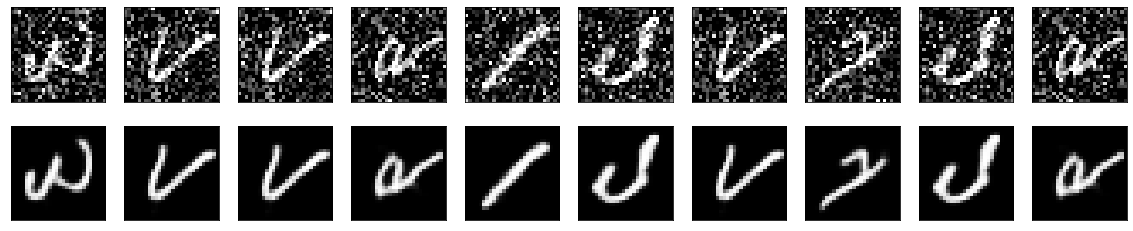

In [140]:
display(x_test.detach().to("cpu"), pred_test.detach().to("cpu"))